In [1]:
from google.colab import drive
drive.mount("/content/drive")
import shutil
from google.colab import files

Mounted at /content/drive


In [2]:
import cv2
import math
import os
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import matplotlib.colors as colors
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, MaxPooling2D, LSTM, Lambda, Conv1D, GlobalMaxPooling1D
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import to_categorical


In [3]:
pressure_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMZ200/MinMaxNormWithLabel"
CL_path = pressure_path + "/CL"
COH_path = pressure_path + "/COH"
COL_path = pressure_path + "/COL"
NROI_path = pressure_path + "/NROI"

In [4]:
CL_files = [f for f in os.listdir(CL_path) if f.endswith('.csv')]
COH_files = [f for f in os.listdir(COH_path) if f.endswith('.csv')]
COL_files = [f for f in os.listdir(COL_path) if f.endswith('.csv')]
NROI_files = [f for f in os.listdir(NROI_path) if f.endswith('.csv')]


In [5]:
array = []
for file in CL_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COH_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COL_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in NROI_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)


In [6]:
train_df = array
train_df = pd.DataFrame(train_df)
train_df.info()
Y = []
for i in range(len(CL_files)):
  Y.append(0)

for i in range(len(COH_files)):
  Y.append(1)

for i in range(len(COL_files)):
  Y.append(2)

for i in range(len(NROI_files)):
  Y.append(3)

train_df["Class"] = Y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Columns: 225 entries, 0 to 224
dtypes: float64(225)
memory usage: 1.3 MB


In [7]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,Class
0,0.475692,0.473846,0.471385,0.468923,0.465846,0.462769,0.460308,0.456615,0.453538,0.450462,...,0.425846,0.424000,0.422769,0.422154,0.423385,0.425846,0.429538,0.435077,0.443077,0
1,0.464615,0.463385,0.462769,0.460923,0.460308,0.457846,0.455385,0.452923,0.451077,0.450462,...,0.429538,0.418462,0.412923,0.411077,0.414769,0.424000,0.437538,0.454769,0.475077,0
2,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.228308,0.220308,0.216000,0.214154,0.216615,0.222769,0.232615,0.246154,0.264615,0
3,0.552000,0.544000,0.536615,0.529846,0.524923,0.521846,0.520000,0.519385,0.520615,0.523077,...,0.460923,0.451077,0.444923,0.443077,0.444923,0.451077,0.461538,0.475077,0.492923,0
4,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.228308,0.220308,0.216000,0.214154,0.216615,0.222769,0.232615,0.246154,0.264615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.865846,0.877538,0.886769,0.896615,0.904615,0.910769,0.917538,0.920615,0.923692,0.926769,...,0.937231,0.929231,0.930462,0.928000,0.924923,0.928615,0.932308,0.934769,0.936000,3
733,0.912615,0.915692,0.923692,0.929846,0.932308,0.935385,0.936615,0.937231,0.937231,0.936615,...,0.937231,0.934769,0.932923,0.929846,0.927385,0.926154,0.926769,0.927385,0.928615,3
734,0.946462,0.944615,0.944615,0.942154,0.938462,0.932308,0.929231,0.933538,0.936615,0.936000,...,0.933538,0.932308,0.929231,0.932923,0.932308,0.933538,0.933538,0.936000,0.939077,3
735,0.856000,0.864000,0.874462,0.876923,0.873846,0.864000,0.868923,0.872615,0.880615,0.889846,...,0.936615,0.936615,0.937231,0.937846,0.936615,0.935385,0.933538,0.931077,0.927385,3


In [8]:
data_path = "/content/drive/MyDrive/Pressure Region of Interest"
arr = []
for file in os.listdir(data_path):
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path, header = None)
    flatten_df = df.to_numpy().flatten()
    name = os.path.splitext(file)[0]
    part = name.split("_")
    day = int(part[0])
    ROI = "" + part[0] + "_" + part[3] + "_" + part[4]
    flatten_df = np.append(flatten_df, name)
    flatten_df = np.append(flatten_df, ROI)
    flatten_df = np.append(flatten_df, day)
    arr.append(flatten_df)

In [9]:
test_data = pd.DataFrame(arr)
test_data.rename(columns={225: "Name", 226: "ROI", 227: "Day"}, inplace = True)
test_data

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,Name,ROI,Day
0,12414,12413,12408,12397,12381,12360,12341,12324,12313,12308,...,12343,12350,12363,12380,12402,12421,12439,3449_c9_cp2_29_58,3449_29_58,3449
1,12313,12316,12317,12314,12310,12305,12302,12300,12302,12305,...,12308,12304,12303,12305,12313,12322,12332,3450_c8_cp2_98_50,3450_98_50,3450
2,12379,12365,12352,12341,12332,12326,12324,12323,12317,12311,...,12377,12386,12397,12411,12424,12434,12441,3450_c8_cp3_59_56,3450_59_56,3450
3,12326,12330,12330,12330,12329,12325,12322,12320,12319,12317,...,12323,12325,12328,12334,12341,12352,12364,3451_c8_cp2_99_50,3451_99_50,3451
4,12437,12434,12431,12428,12427,12426,12425,12425,12426,12428,...,12444,12455,12465,12475,12483,12486,12494,3452_c8_cp3_55_59,3452_55_59,3452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,11938,11928,11919,11910,11902,11894,11888,11881,11874,11868,...,11987,11997,12009,12022,12038,12054,12070,1648_c3_cp2_15_28,1648_15_28,1648
3648,12510,12507,12510,12508,12505,12500,12496,12492,12488,12483,...,12453,12453,12458,12464,12473,12477,12483,1648_c9_cp3_65_62,1648_65_62,1648
3649,12443,12457,12466,12476,12480,12487,12488,12494,12490,12486,...,12478,12470,12468,12466,12466,12466,12464,1649_c11_cp1_61_51,1649_61_51,1649
3650,11833,11833,11833,11834,11834,11834,11833,11833,11834,11835,...,11877,11889,11904,11921,11941,11963,11987,1649_c3_cp2_16_25,1649_16_25,1649


In [10]:
test_data["Day"] = test_data["Day"].astype(int)
test_df = test_data[(test_data["Day"] >= 730) & (test_data["Day"] <= 1095)]
test_df = test_df.drop_duplicates(subset = "ROI")
test_df = test_df[test_df["ROI"] != "738_73_20"]
test_df = test_df.sort_values(by = "Name")
test_df.reset_index(drop = True, inplace = True)
test_df

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,Name,ROI,Day
0,12333,12335,12337,12339,12339,12340,12338,12336,12333,12328,...,12371,12370,12371,12375,12379,12390,12394,1001_c12_cp2_63_48,1001_63_48,1001
1,12395,12385,12372,12359,12344,12328,12312,12296,12280,12267,...,12273,12278,12289,12301,12316,12331,12345,1002_c11_cp2_41_44,1002_41_44,1002
2,12345,12369,12391,12411,12428,12443,12457,12468,12477,12483,...,12488,12483,12475,12466,12456,12446,12434,1002_c15_cp1_20_48,1002_20_48,1002
3,12477,12467,12455,12442,12429,12415,12402,12390,12380,12372,...,12393,12400,12408,12415,12421,12426,12429,1003_c11_cp2_38_48,1003_38_48,1003
4,12426,12426,12423,12416,12407,12398,12390,12383,12378,12376,...,12323,12326,12366,12367,12374,12388,12407,1004_c10_cp2_30_49,1004_30_49,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,12469,12476,12481,12473,12474,12465,12459,12455,12457,12462,...,12467,12462,12464,12470,12480,12490,12496,997_c12_cp2_62_59,997_62_59,997
327,12343,12349,12351,12350,12346,12341,12335,12331,12328,12325,...,12334,12346,12362,12380,12397,12413,12427,998_c12_cp2_37_48,998_37_48,998
328,12118,12142,12161,12175,12185,12191,12196,12201,12204,12205,...,12238,12237,12232,12225,12216,12210,12206,999_c11_cp2_102_34,999_102_34,999
329,12227,12241,12249,12252,12255,12258,12262,12268,12274,12282,...,12316,12330,12349,12369,12389,12410,12430,999_c11_cp3_37_44,999_37_44,999


In [11]:
#Train and Test data
X_train = train_df.drop("Class", axis = 1)
Y_train = train_df["Class"]

X_test = test_df.drop(columns = ["Day", "Name", "ROI"])

#Normalize testing data
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

In [ ]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled
#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [ ]:
num_rows = 15
num_cols = 15
max_m_dsitance = 7
max_learning_rate = 0.75
max_steps = 20000

In [ ]:
#main function

train_x_norm = minmax_scaler(X_train) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
SOM training completed


In [ ]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

In [ ]:
map_table = {}
for i in range(len(map)):
    for j in range(len(map[0])):
        if len(map[i][j]) == 0:
            map_table[i, j] = [None]
        else:
            hash_table = {}
            for k in map[i][j]:
                if k in hash_table:
                    hash_table[k] += 1
                else:
                    hash_table[k] = 1
            for key, value in hash_table.items():
                percentage = [key, round((value / len(map[i][j])), 2)]
                if (i, j) not in map_table:
                    map_table[i, j] = []
                map_table[i, j].append(percentage)


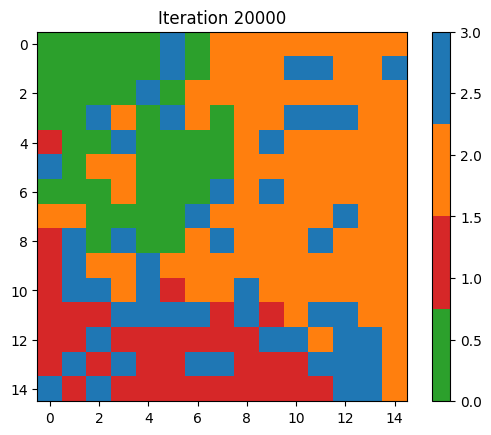

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(X_test) # normalisation

winner_labels = []
pre_labels = []

for t in range(data.shape[0]):
  winner = winning_neuron(data, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  pred = map_table[row, col]
  predicted = label_map[row][col]
  pre_labels.append(pred)
  winner_labels.append(predicted)



In [18]:
labels_df = pd.read_table("/content/3rd_year_Categorical_ROI.txt", sep = ":", header = None)
labels_df.rename(columns = {0: "Name", 1: "Class"}, inplace = True)
labels_df["Class"] = labels_df["Class"].str.strip()
labels_df = labels_df.sort_values(by = 'Name')
labels_df.reset_index(drop = True, inplace = True)
labels_df

,Name,Class
0,1001_c12_cp2_63_48,NROI
1,1002_c11_cp2_41_44,COL
2,1002_c15_cp1_20_48,COH
3,1003_c11_cp2_38_48,COL
4,1004_c10_cp2_30_49,COL
...,...,...
326,997_c12_cp2_62_59,NROI
327,998_c12_cp2_37_48,COL
328,999_c11_cp2_102_34,COL
329,999_c11_cp3_37_44,COL


In [19]:
class_mapping = {'NROI': 3, 'COL': 2, 'COH': 1, 'CL': 0}
labels_df["Class"] = labels_df["Class"].replace(class_mapping)
labels_df

,Name,Class
0,1001_c12_cp2_63_48,3
1,1002_c11_cp2_41_44,2
2,1002_c15_cp1_20_48,1
3,1003_c11_cp2_38_48,2
4,1004_c10_cp2_30_49,2
...,...,...
326,997_c12_cp2_62_59,3
327,998_c12_cp2_37_48,2
328,999_c11_cp2_102_34,2
329,999_c11_cp3_37_44,2


In [20]:
labels_df["Class"] = labels_df["Class"].astype(int)

In [ ]:
SOM_acc = accuracy_score(np.array(labels_df["Class"]), np.array(winner_labels))
print("Accuracy: ", SOM_acc)

Accuracy:  0.5830815709969789


In [ ]:

SOM_test_df = test_df.copy()
SOM_test_df["Class"] = winner_labels
SOM_test_df["Percentage"] = pre_labels
SOM_test_df

<ipython-input-20-1e4c382ae0b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOM_test_df["Class"] = winner_labels
<ipython-input-20-1e4c382ae0b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOM_test_df["Percentage"] = pre_labels


,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,Name,Day,Class,Percentage
0,11653,11670,11686,11699,11710,11719,11728,11733,11737,11738,...,11782,11772,11758,11739,11715,11688,730_c12_cp1_24_28,730,1,"[[1, 1.0]]"
1,11691,11705,11717,11727,11734,11742,11746,11746,11746,11742,...,11779,11777,11774,11767,11758,11746,731_c12_cp1_24_27,731,1,"[[1, 1.0]]"
2,11704,11716,11725,11734,11741,11745,11746,11746,11744,11739,...,11782,11781,11776,11767,11755,11738,732_c13_cp1_25_25,732,1,"[[1, 1.0]]"
3,10820,10817,10813,10811,10809,10807,10806,10805,10805,10805,...,10806,10808,10810,10814,10818,10824,733_c1_cp1_83_11,733,0,"[[0, 1.0]]"
4,10914,10904,10895,10887,10879,10873,10866,10862,10857,10854,...,10909,10917,10926,10935,10944,10953,736_c1_cp1_77_11,736,0,"[[0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,12228,12246,12260,12272,12281,12289,12295,12301,12305,12306,...,12323,12329,12334,12339,12344,12350,1055_c16_cp2_99_60,1055,2,"[[2, 0.5], [3, 0.5]]"
353,11585,11596,11606,11615,11623,11628,11633,11637,11639,11640,...,11682,11678,11673,11666,11656,11645,1069_c11_cp1_15_27,1069,1,"[[1, 1.0]]"
354,12347,12330,12310,12286,12261,12236,12212,12192,12176,12167,...,12204,12215,12228,12243,12256,12265,1087_c16_cp2_17_59,1087,2,"[[2, 1.0]]"
355,12354,12344,12333,12322,12311,12300,12291,12282,12274,12267,...,12284,12283,12278,12279,12284,12289,1090_c17_cp2_27_63,1090,3,[None]


In [ ]:
# Assuming your DataFrame is named "SOM_test_df"
SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [] if x == [None] else x)

# Print the updated DataFrame
SOM_test_df

<ipython-input-54-4cd4b0dab110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [] if x == [None] else x)


,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,Name,Day,Class,Percentage
0,11653,11670,11686,11699,11710,11719,11728,11733,11737,11738,...,11782,11772,11758,11739,11715,11688,730_c12_cp1_24_28,730,1,"[[1, 1.0]]"
1,11691,11705,11717,11727,11734,11742,11746,11746,11746,11742,...,11779,11777,11774,11767,11758,11746,731_c12_cp1_24_27,731,1,"[[1, 1.0]]"
2,11704,11716,11725,11734,11741,11745,11746,11746,11744,11739,...,11782,11781,11776,11767,11755,11738,732_c13_cp1_25_25,732,1,"[[1, 1.0]]"
3,10820,10817,10813,10811,10809,10807,10806,10805,10805,10805,...,10806,10808,10810,10814,10818,10824,733_c1_cp1_83_11,733,0,"[[0, 1.0]]"
4,10914,10904,10895,10887,10879,10873,10866,10862,10857,10854,...,10909,10917,10926,10935,10944,10953,736_c1_cp1_77_11,736,0,"[[0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,12228,12246,12260,12272,12281,12289,12295,12301,12305,12306,...,12323,12329,12334,12339,12344,12350,1055_c16_cp2_99_60,1055,2,"[[2, 0.5], [3, 0.5]]"
353,11585,11596,11606,11615,11623,11628,11633,11637,11639,11640,...,11682,11678,11673,11666,11656,11645,1069_c11_cp1_15_27,1069,1,"[[1, 1.0]]"
354,12347,12330,12310,12286,12261,12236,12212,12192,12176,12167,...,12204,12215,12228,12243,12256,12265,1087_c16_cp2_17_59,1087,2,"[[2, 1.0]]"
355,12354,12344,12333,12322,12311,12300,12291,12282,12274,12267,...,12284,12283,12278,12279,12284,12289,1090_c17_cp2_27_63,1090,3,[]


In [ ]:
def calculate_distance(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    distance = math.sqrt(delta_x**2 + delta_y**2)
    return distance

In [ ]:
SOM_ROI = {}

data = SOM_test_df.to_numpy()
for item in data:
    part = item[225].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[227]
    percentage = item[228]
    if day in SOM_ROI:
        found_duplicate = False
        for ele in SOM_ROI[day]:
            if x == ele[0] and y == ele[1]:
                found_duplicate = True
                break
        if not found_duplicate:
            SOM_ROI[day].append([x, y, category, percentage])
    else:
        SOM_ROI[day] = [[x, y, category, percentage]]


In [ ]:
One_SOM_ROI = {}
Many_SOM_ROI = {}

for key, value in SOM_ROI.items():
    if len(value) <= 1:
        One_SOM_ROI[key] = value
    else:
        Many_SOM_ROI[key] = value

In [ ]:
Many_SOM = {}
for key, value in Many_SOM_ROI.items():
    Many_SOM[key] = [[value[0]]]
    max_len = 0
    for i in value:
        if i[3] is None:
            continue
        else:
            if max_len < len(i[3]):
                max_len = len(i[3])
    space = max_len * 12 + (max_len - 1) * 6 + 16
    i = 1
    while i < len(value):
        x1 = value[i][0]
        y1 = value[i][1]
        found_smaller = True
        for k in Many_SOM[key]:
            found_smaller = True
            for j in k:
                x2 = j[0]
                y2 = j[1]
                distance = calculate_distance(x1, y1, x2, y2)
                if distance < space:
                    found_smaller = False
                    break
            if found_smaller == True:
                k.append(value[i])
                break
        if found_smaller == False:
            Many_SOM[key].append([value[i]])
        i += 1

In [ ]:
Many_SOM

In [ ]:
folder_name = "3rd_SOM_Categorical_ROI_Pressure_Image"
SOM_folder_path = "/content/drive/MyDrive/" + folder_name

# os.makedirs(folder_path)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
default_color = (0, 0, 0)
size = 1
text_color = (148, 91, 10)

In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    final_image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])

    if number in One_SOM_ROI:
        for point in One_SOM_ROI[number]:
            x = point[0]
            y = point[1]
            color = color_list.get(point[2], default_color)
            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
            cv2.drawContours(final_image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
            text = ""
            if point[3] is not None:
                text = ", ".join([f"{a}:{b}" for a, b in point[3]])
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.2
            line_thickness = 0
            position = ()
            lines = text.split(",")
            max_len * 12 + (max_len - 1) * 6 + 16
            if x < len(lines) * 12 + (len(lines) - 1) * 6 + 16:
                position = (x + 3, y - 2)
            else:
                position = (x - 11, y + 8)
            for i, line in enumerate(lines):
                line = line.strip()
                position = (position[0], position[1] + 6 * i)
                cv2.putText(final_image, line, position, font, font_scale, text_color, line_thickness)
        cv2.imwrite(SOM_folder_path + "/day" + str(number) + ".png", final_image)




In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    f_image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])

    height, width, _ = f_image.shape
    base_image = np.zeros((height, width, 3), dtype = np.uint8)
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    if number in Many_SOM:
        for part in Many_SOM[number]:
            image = f_image.copy()
            for point in part:
                x = point[0]
                y = point[1]
                color = color_list[point[2]]
                vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
                cv2.drawContours(image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
                text = ""
                if point[3] is not None:
                    text = ", ".join([f"{a}:{b}" for a, b in point[3]])
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.2
                line_thickness = 0
                position = ()
                lines = text.split(",")
                max_len * 12 + (max_len - 1) * 6 + 16
                if x < len(lines) * 12 + (len(lines) - 1) * 6 + 16:
                    position = (x + 3, y - 2)
                else:
                    position = (x - 11, y + 8)
                for i, line in enumerate(lines):
                    line = line.strip()
                    position = (position[0], position[1] + 6 * i)
                    cv2.putText(image, line, position, font, font_scale, text_color, line_thickness)
            base_image = np.concatenate((base_image, image), axis = 1)
        base_image = base_image[:, width:, :]
        cv2.imwrite(SOM_folder_path + "/day" + str(number) + ".png", base_image)


#**CNN**

In [12]:
#Reshape training and testing data
train_X = X_train.to_numpy().reshape(X_train.shape[0],15,15,1).astype("float32")

train_Y = Y_train.to_numpy()

test_X = np.array(X_test).reshape(X_test.shape[0], 15, 15, 1)

train_Y = tf.keras.utils.to_categorical(train_Y)

In [ ]:
#Define the model architecture
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = (15, 15, 1)))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=30)

# Fit the model
model.fit(train_X, train_Y, epochs=1000, batch_size=32, callbacks = early_stopping)

In [13]:
#Define the model architecture
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = (15, 15, 1)))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='loss', patience=30)

# Fit the model
model.fit(train_X, train_Y, epochs=1000, batch_size=32, callbacks = early_stopping)

Epoch 1/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3606 - accuracy: 0.8562
Epoch 2/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3398 - accuracy: 0.8670
Epoch 3/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3267 - accuracy: 0.8657
Epoch 4/1000
24/24 [==============================] - 1s 22ms/step - loss: 0.3200 - accuracy: 0.8765
Epoch 5/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3285 - accuracy: 0.8630
Epoch 6/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3205 - accuracy: 0.8684
Epoch 7/1000
24/24 [==============================] - 1s 23ms/step - loss: 0.3173 - accuracy: 0.8725
Epoch 8/1000
24/24 [==============================] - 1s 24ms/step - loss: 0.3120 - accuracy: 0.8752
Epoch 9/1000
24/24 [==============================] - 1s 38ms/step - loss: 0.3397 - accuracy: 0.8630
Epoch 10/1000
24/24 [==============================] - 1s 24ms/step - loss: 0.3088 - accura

In [23]:
y_pred = model.predict(test_X).argmax(axis=1)

11/11 [==============================] - 0s 12ms/step


In [27]:
CNN_acc = accuracy_score(np.array(labels_df["Class"]), y_pred)
print("Accuracy: ", CNN_acc)

Accuracy:  0.743202416918429


In [28]:
print(confusion_matrix(np.array(labels_df["Class"]), y_pred))

[[77  1 11  0]
 [ 2 77  0  0]
 [31  0 56  0]
 [ 1  4 35 36]]


In [ ]:
testing_df = test_df.copy()
testing_df["Class"] = y_pred
testing_df

<ipython-input-58-58b3da172b34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df["Class"] = y_pred


,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,Name,Day,Class
0,11653,11670,11686,11699,11710,11719,11728,11733,11737,11738,...,11787,11782,11772,11758,11739,11715,11688,730_c12_cp1_24_28,730,1
1,11691,11705,11717,11727,11734,11742,11746,11746,11746,11742,...,11777,11779,11777,11774,11767,11758,11746,731_c12_cp1_24_27,731,1
2,11704,11716,11725,11734,11741,11745,11746,11746,11744,11739,...,11780,11782,11781,11776,11767,11755,11738,732_c13_cp1_25_25,732,1
3,10820,10817,10813,10811,10809,10807,10806,10805,10805,10805,...,10805,10806,10808,10810,10814,10818,10824,733_c1_cp1_83_11,733,0
4,10914,10904,10895,10887,10879,10873,10866,10862,10857,10854,...,10901,10909,10917,10926,10935,10944,10953,736_c1_cp1_77_11,736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,12228,12246,12260,12272,12281,12289,12295,12301,12305,12306,...,12318,12323,12329,12334,12339,12344,12350,1055_c16_cp2_99_60,1055,2
353,11585,11596,11606,11615,11623,11628,11633,11637,11639,11640,...,11683,11682,11678,11673,11666,11656,11645,1069_c11_cp1_15_27,1069,1
354,12347,12330,12310,12286,12261,12236,12212,12192,12176,12167,...,12198,12204,12215,12228,12243,12256,12265,1087_c16_cp2_17_59,1087,2
355,12354,12344,12333,12322,12311,12300,12291,12282,12274,12267,...,12284,12284,12283,12278,12279,12284,12289,1090_c17_cp2_27_63,1090,2


In [ ]:
CNN_ROI = {}
data = testing_df.to_numpy()
for item in data:
    part = item[225].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[227]
    if day in CNN_ROI:
        CNN_ROI[day].append([x, y, category])
    else:
        CNN_ROI[day] = [[x, y, category]]

In [ ]:
folder_name = "3rd_CNN_Categorical_ROI_Pressure_Image"
folder_path = "/content/drive/MyDrive/" + folder_name

os.makedirs(folder_path)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    final_img = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])

    if number in CNN_ROI:
        for point in CNN_ROI[number]:
            x = point[0]
            y = point[1]
            color = color_list[point[2]]

            size = 2

            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])

            cv2.drawContours(final_img, [vertices.reshape((-1, 1, 2))], -1, color, thickness = cv2.FILLED)

        cv2.imwrite(folder_path + "/day" + str(number) + ".png", final_img)

In [ ]:
#Accuracy
# SOM Accuracy
print("SOM accuracy: ", SOM_acc)

# SOM Accuracy
print("CNN accuracy: ", CNN_acc)

SOM accuracy:  0.5830815709969789
CNN accuracy:  0.7371601208459214
